# Lab 11. Inne przykłady wykresów `plotly` oraz analiza głównych składowych

## 1. Kilka innych przykładów wykresów z biblioteką `plotly`

In [55]:
# zainstaluj, jeżeli brakuje biblioteki
import plotly as py
import datetime
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import widgets

In [56]:
# some more libraries to plot graph
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot


init_notebook_mode(connected = True)

data = dict(type = 'choropleth',

            # kody krajów: https://country.io/iso3.json
            locations = ['POL', 'DEU', 'FRA'],
            
            # Europa
            locationmode = 'ISO-3',
            
            # skala kolorów
            colorscale = 'Greens',
            
            # tekst dodatkowo wyświetlany obok wartości po najechaniu na obszar
            text = ['text 1', 'text 2', 'text 3'],
            # faktyczny wektor wartości, który reprezentuje poszczególne kraje
            z = [1.0, 2.0, 3.0],
            colorbar = {'title': 'Skala wartości'})
            
layout = dict(geo ={'scope': 'europe'})

choromap = go.Figure(data = [data], layout = layout)

iplot(choromap)

Inne wykresy oparte o otwarte mapy dostępne są pod linkiem: https://plotly.com/python/tile-county-choropleth/

### 1.1 Przykład wykresów interaktywnych

> **UWAGA!**  
> Poniższe przykłady ilustrują możliwe wykorzystanie iPyWidgets oraz plotly do tworzenia interaktywnych wykresów w Jupyter Notebook,
> jednak nie zawsze działają poprawnie z przyczyn póki co niewyjaśnionych.
>
> Lista kontrolek: https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html#date-picker

In [58]:
# wczytujemy zbiór danych
df = pd.read_csv('../lab_10/data/zamowienia.csv', sep=';')
# konwersja kolumny z datą
df['Data zamowienia'] = pd.to_datetime(df['Data zamowienia'])
df.head()

,Kraj,Sprzedawca,Data zamowienia,idZamowienia,Utarg
0,Polska,Kowalski,2003-07-16,10248,440.00
1,Polska,Sowiński,2003-07-10,10249,1863.40
2,Niemcy,Peacock,2003-07-12,10250,1552.60
3,Niemcy,Leverling,2003-07-15,10251,654.06
4,Niemcy,Peacock,2003-07-11,10252,3597.90


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Kraj             799 non-null    object        
 1   Sprzedawca       799 non-null    object        
 2   Data zamowienia  799 non-null    datetime64[ns]
 3   idZamowienia     799 non-null    int64         
 4   Utarg            799 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 31.3+ KB


In [59]:


kraj = widgets.Dropdown(
    options=list(df['Kraj'].unique()),
    value=df['Kraj'][0],
    description='Kraj:',
)
 

sprzedawca = widgets.Dropdown(
    description='Sprzedawca:   ',
    value=df[df['Kraj'] == kraj.value]['Sprzedawca'][0],
    options=df[df['Kraj'] == kraj.value]['Sprzedawca'].unique().tolist()
)


trace2 = go.Histogram(x=df['Utarg'], opacity=0.75, name='Rozkład utargu')
g1 = go.FigureWidget(data=[trace2],
                    layout=go.Layout(
                        title=dict(
                            text='Sprzedaż'
                        ),
                        barmode='overlay'
                    ))

In [60]:
def validate():
    if kraj.value in df['Kraj'].unique() and sprzedawca.value in df['Sprzedawca'].unique():
        return True
    else:
        return False


def response(change):
    # update values for sprzedawca
    sprzedawca.options = df[df['Kraj'] == kraj.value]['Sprzedawca'].unique().tolist()
    if validate():
        data = df[(df['Sprzedawca'] == sprzedawca.value) & (df['Kraj'] == kraj.value)]
        with g1.batch_update():
            g1.data[0].x = data['Utarg']
            # g.layout.xaxis = 'Etykieta'
            # g.layour.yaxis = 'Etykieta'

# dodanie nasłuchiwania zmiany wartości w kontrolkach
kraj.observe(response, names="value")
sprzedawca.observe(response, names="value")

In [61]:
g1

FigureWidget({
    'data': [{'name': 'Rozkład utargu',
              'opacity': 0.75,
              'type': 'histogram',
              'uid': '1fbc37f6-3910-4d31-8896-f35aeab97582',
              'x': {'bdata': ('AAAAAACAe0CamZmZmR2dQGZmZmZmQp' ... 'AAAN6nQAAAAAAAOK1AAAAAAACARkA='),
                    'dtype': 'f8'}}],
    'layout': {'barmode': 'overlay', 'template': '...', 'title': {'text': 'Sprzedaż'}}
})

In [62]:
container2 = widgets.HBox([kraj, sprzedawca])
widgets.VBox([container2, g1])

In [63]:
# dane, które zostaną przedstawione na wykresie to suma skumulowana wartości zamowienia po dacie
plot_data = df[['Kraj', 'Data zamowienia','Utarg']].groupby(['Kraj', 'Data zamowienia']).agg({'Utarg': 'sum'}).cumsum()
plot_data = plot_data.reset_index()
plot_data

,Kraj,Data zamowienia,Utarg
0,Niemcy,2003-07-11,3597.90
1,Niemcy,2003-07-12,5150.50
2,Niemcy,2003-07-15,5804.56
3,Niemcy,2003-07-16,7249.36
4,Niemcy,2003-07-17,7767.16
...,...,...,...
500,Polska,2005-04-24,1214099.48
501,Polska,2005-04-27,1226774.53
502,Polska,2005-04-29,1226984.53
503,Polska,2005-04-30,1227509.53


In [64]:
# deklaracja widgetów

kraj = widgets.Dropdown(
    options=list(plot_data['Kraj'].unique()),
    value=plot_data['Kraj'][0],
    description='Kraj:',
)

# deklaracja wykresu
fig = go.Scatter(x=plot_data['Utarg'], name='Skumulowany utarg', mode='lines')

g2 = go.FigureWidget(data=[fig],
                    layout=go.Layout(
                        title=dict(
                            text='Sprzedaż skumulowana'
                        ),
                        barmode='overlay'
                    ))

# funkcja walidująca poprawność danych w kontrolkach
def validate():
    if kraj.value in plot_data['Kraj'].unique():
        return True
    else:
        return False

# funkja uruchamiana przy zmianie stanu kontrolki (aktualizuje wykres)
def response(change):
    if validate():
        dat = plot_data[plot_data['Kraj'] == kraj.value]
        with g2.batch_update():
            g2.data[0].x = dat['Utarg']
            # g.layout.xaxis = 'Data'
            # g.layour.yaxis = 'Wartość zamówienia'


kraj.observe(response, names="value")

In [65]:
g2

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'Skumulowany utarg',
              'type': 'scatter',
              'uid': '8b5f8fbe-1dd6-4c54-a093-6256726f8773',
              'x': {'bdata': ('zczMzMwbrEAAAAAAgB60QML1KFyPrL' ... '6H6LgyQX0Urof1ujJBaWZmZie+MkE='),
                    'dtype': 'f8'}}],
    'layout': {'barmode': 'overlay', 'template': '...', 'title': {'text': 'Sprzedaż skumulowana'}}
})

In [66]:
container = widgets.HBox([kraj])
widgets.VBox([container, g2])

## 2. Analiza głównych składowych (PCA)

In [ ]:
!pip install scikit-learn

In [67]:
# wykorzystanie przykładów redukcji wymiarowości z wykładu

# dodanie wizualizacji wybranych cech, aby pokazać ich rozkład pod analizę
# ale może i aby dokonać wyboru mechanizmu redukcji wymiarowości

# policzenie wariancji, aby to również wskazać

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, KernelPCA

In [68]:
# wczytujemy zbiór danych iris

iris = load_iris()
feature_names = iris.feature_names
feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

**Najpierw przeprowadzimy liniową redukcję wymiarowości**

In [69]:
pca = PCA(n_components=2)        # redukcja do 2 wymiarów
reduced = pca.fit_transform(iris.data)

In [70]:
# oryginalny shape (rows, columns/features) vs. po redukcji wymiarów
iris.data.shape, reduced.shape

((150, 4), (150, 2))

In [72]:
# jak wygląda wyliczona wariancja dla zwróconych cech
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

In [64]:
# sumarycznie wyjdzie nam, że te dwie cechy opisują niemal 98% zmienności z tych danych
sum(pca.explained_variance_ratio_)

np.float64(0.9776852063187963)

In [73]:
# jak wygląda nowy zbiór cech
pca.get_feature_names_out()

array(['pca0', 'pca1'], dtype=object)

**Inny przykład**

In [91]:
# scalamy dane ze zbioru iris z scikit learn w ramkę danych
iris_df = pd.DataFrame(np.hstack([iris.data, np.expand_dims(iris.target, axis=1)]), columns=iris.feature_names + ['target'])

In [92]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [93]:
pca = PCA(n_components=.99)        # redukcja do poziomu minimum 99% zachowanej wariancji
# pca.feature_names_in_ = iris_df.columns[:-1]
reduced = pca.fit_transform(iris_df[iris_df.columns[:-1]], iris_df[iris_df.columns[-1]])  

In [94]:
# oryginalny shape (rows, columns/features) vs. po redukcji wymiarów
iris.data.shape, reduced.shape

((150, 4), (150, 3))

In [95]:
pca.explained_variance_ratio_

array([0.92461872, 0.05306648, 0.01710261])

In [96]:
# sumarycznie wyjdzie nam, że te dwie cechy opisują niemal 99.5% zmienności z tych danych
sum(pca.explained_variance_ratio_)

np.float64(0.9947878161267256)

In [97]:
# nazwy cech w zbiorze wynikowym (ale to nam niewiele mówi)
pca.get_feature_names_out()

array(['pca0', 'pca1', 'pca2'], dtype=object)

In [98]:
# liczba cech wejściowych
pca.n_features_in_

4

In [99]:
# składowe każdego nowego wymiaru zbioru (n_components × n_features_in)
pca.components_

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102],
       [-0.58202985,  0.59791083,  0.07623608,  0.54583143]])

In [100]:
# sumaryczna waga każdej cechy
np.sum(np.abs(pca.components_), axis=0)

array([1.60000521, 1.41259478, 1.10627934, 0.97960165])

Wychodzi na to, że cecha `petal width` charakteryzuje się najmniejszą wagą i powinna zostać odrzucona jako pierwsza. Kolejna byłaby cecha `petal length` itd.

Możemy to również policzyć z danych wyliczonych przez algorytm PCA.

In [101]:
# sortujemy cechy od najważniejszych do najmniej ważnych w kontekście miary wykorzystanej przez algorytm PCA
features_order = np.argsort(np.sum(np.abs(pca.components_), axis=0))[::-1]

In [102]:
pca.feature_names_in_[features_order].tolist()

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

OK, widzimy, że PCA zredukowało wymiar cech w zbiorze automatycznie na podstawie wariancji odrzucając jedną cechę. Redukcja liczby cech następuje tak długo, póki usunięcie kolejnej cechy nie zejdzie poniżej założonego progu sumarycznej wariancji. Ale jak wygląda sprawa z intuicją liniowej redukcji wymiarów?

Popatrzmy na wykres poniżej, który prezentuje macierz rozkładu wartości klasy decyzyjnej (species, u nas target) dla każdej cechy zbioru. Jeżeli znajdziemy takie cechy, których punkty dla klasy decyzyjnej nie nachodzą na siebie gdybyśmy je rzutowali na linię (bo tu mamy 2 wymiary, rzutujemy na 1 wymiar), co oznacza, że są separowalne liniowo, to są to algorytm liniowy PCA na pewno będzie wybierał je jako pierwsze do odrzucenia.

In [103]:
import plotly.express as px

df = px.data.iris()
features = ["sepal_width", "sepal_length", "petal_width", "petal_length"]

fig = px.scatter_matrix(
    df,
    dimensions=features,
    color="species"
)
fig.update_traces(diagonal_visible=False)
fig.show()

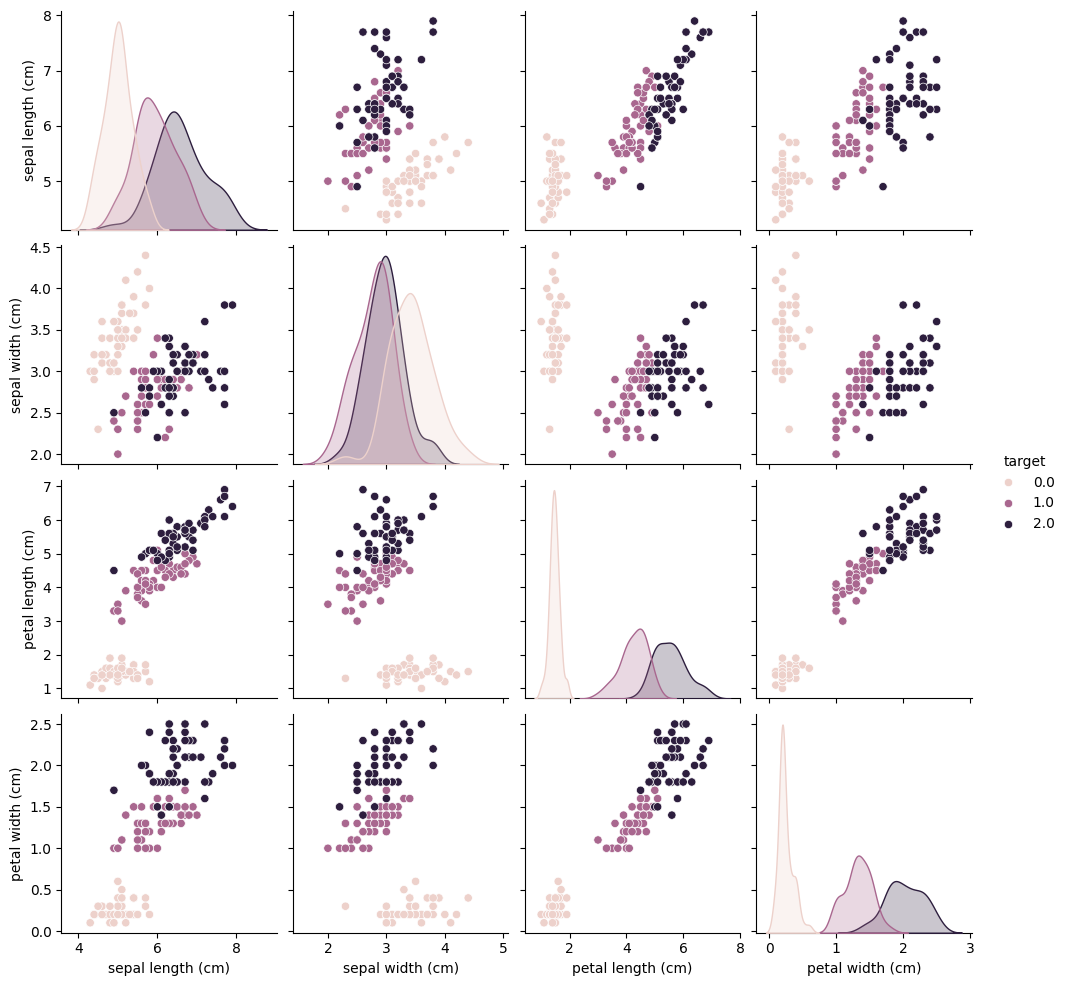

In [104]:
# ten sam (niemal) wykres, ale za pomocą biblioteki seaborn
import seaborn as sns

# Rename classes using the iris target names
_ = sns.pairplot(iris_df, hue="target")

**Wyświetlamy ponownie taki sam typ wykresu dla nowych cech zbioru po redukcji wymiarowości**

In [105]:
reduced_df = pd.DataFrame(np.hstack([reduced, np.expand_dims(iris_df.iloc[:, -1], axis=1)]))
reduced_df.head()

,0,1,2,3
0,-2.684126,0.319397,-0.027915,0.0
1,-2.714142,-0.177001,-0.210464,0.0
2,-2.888991,-0.144949,0.017900,0.0
3,-2.745343,-0.318299,0.031559,0.0
4,-2.728717,0.326755,0.090079,0.0


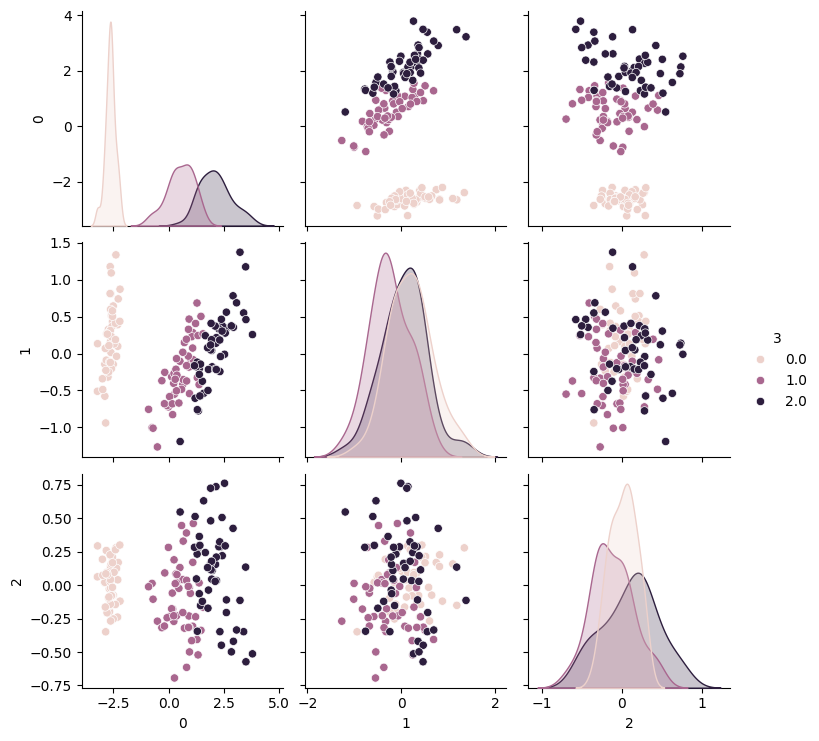

In [106]:
_ = sns.pairplot(reduced_df, hue=3)

## Zadania

**Zadanie 1**

Wykorzystując dowolny zbiór danych ze zbioru EUROSTAT, wyświetl jedną z cech numerycznych w postaci wykresu z mapą z przykładu w tym labie. Musisz dokonać mapowania nazw krajów, gdyż w parametrach wykresu oraz danych EUROSTAT gdyż te nazwy się trochę różnią. Link do pliku, który to ułatwi jest w komentarzu w kodzie przykładu wykresu z mapą.

**Zadanie 2**

Wykorzystując zbiór wine z biblioteki sklearn (`load_wine()`), podobnie jak ze zbiorze iris) dokonaj analizy PCA tak aby:
* zachować minimum 99% wariancji
* zachować minimum 95% wariancji
* zachować minimum 90% wariancji

Ile cech pozostało w tych zbiorach?

**Zadanie 3**  

Wykorzystując przykład w labie wygeneruj wykres korelacji wartości cech wględem klasy decyzyjnej (target) pokazany w labie (scatter plot). Czy cechy, które PCA odrzuciło faktycznie były wskazane jako najlepsi kandydaci pod względem separowalności liniowej?

**Zadanie 4**  

Wykorzystując przykład w skrypcie z wykładu numer 11 (https://github.com/agazbrzezny/MAD_SWPS_2025/blob/master/wyklad_10/redukcja_wielowym.ipynb) pokazujący użycie `SelectFromModel` (punkt 4 wykładu) wykonaj tę samą sekwencję czynności z użyciem klasyfikatora RandomForest do selekcji cech. Po przetrenowaniu modelu drzewa stwórz 3 zbiory cech z progiem jak w zadaniu 2 sumując `feature importance`. Czy zostały wybrane te same cechy co w zadaniu 2?